# Техническое задание: Маркетинг

## Описание
Интернет-магазин анализирует историю покупок клиентов, отправляет предложения и планирует будущие продажи. Для оптимизации этих процессов необходимо выделить пользователей, готовых сделать покупку в ближайшие дни.

## Цель
Предсказать вероятность совершения покупки в течение следующих 90 дней.

## Задачи
- Анализ данных
- Разработка полезных признаков
- Создание модели для классификации пользователей
- Улучшение модели с целью максимизации метрики ROC-AUC
- Проведение тестирования модели

## Данные

### apparel-purchases
**История покупок**  
- `client_id` — идентификатор пользователя
- `quantity` — количество товаров в заказе
- `price` — цена товара
- `category_ids` — вложенные категории, к которым относится товар
- `date` — дата покупки
- `message_id` — идентификатор сообщения из рассылки

### apparel-messages
**История рекламных рассылок**  
- `bulk_campaign_id` — идентификатор рекламной кампании
- `client_id` — идентификатор пользователя
- `message_id` — идентификатор сообщений
- `event` — тип действия
- `channel` — канал рассылки
- `date` — дата рассылки
- `created_at` — точное время создания сообщения

### apparel-target_binary
**Совершит ли клиент покупку в течение следующих 90 дней**  
- `client_id` — идентификатор пользователя
- `target` — целевой признак

## План проведения исследования
1. Анализ данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Генерация новых признаков
5. Создание нескольких классификационных моделей и выбор наилучшей
6. Оценка качества модели с использованием метрики ROC-AUC
7. Формулировка выводов


## Загрузка библиотек.

In [4]:
pip install lightgbm -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Стандартные библиотеки
import os
import re

# Библиотеки для работы с данными
import numpy as np
import pandas as pd

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import phik

# Библиотеки для машинного обучения
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, OrdinalEncoder)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (RandomizedSearchCV, train_test_split, cross_val_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

# Метрики
from sklearn.metrics import roc_auc_score

## Установка параметров проекта.

In [6]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Создадим функции для проекта.

Функция чтобы оставить только числа для колонки `category_ids`

In [7]:
def extract_numbers(category_ids):
    numbers = re.findall(r'\d+', category_ids)
    return ' '.join(numbers)

Функция для проверки количественных значений.

In [8]:
def visualize_distribution(data, col, bins=20, color_hist='skyblue', color_box='lightgreen', figsize=(14, 7)):

    display(data[col].describe())

    sns.set(style="whitegrid")

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    sns.histplot(data[col], bins=bins, ax=axes[0], color=color_hist, kde=True)
    axes[0].set_title('Гистограмма распределения', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Наблюдаемые значения', fontsize=12)
    axes[0].set_ylabel('Частота встречаемости', fontsize=12)

    sns.boxplot(y=data[col], ax=axes[1], color=color_box, linewidth=2.5)
    axes[1].set_title('Разброс значений признаков', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Категория', fontsize=12)
    axes[1].set_ylabel('Наблюдаемые значения', fontsize=12)

    plt.tight_layout()

    plt.show()

Функцию проверки категориальных значений.

In [9]:
def visualize_category_distribution(data, cat, palette='Set2', figsize=(20, 10), title_size=16, label_size=12):

    plt.figure(figsize=figsize)
    ax = sns.countplot(x=data[cat], order=data[cat].value_counts(ascending=False).index, palette=palette)

    abs_values = data[cat].value_counts(ascending=False).values
    ax.bar_label(container=ax.containers[0], labels=abs_values)

    ax.set_title('Распределение категорий признака ' + cat, fontsize=title_size, fontweight='bold')
    ax.set_xlabel('Категории', fontsize=label_size)
    ax.set_ylabel('Частота встречаемости', fontsize=label_size)

    plt.show()

Функция проверки топ категорий.

In [10]:
def visualize_top_category_distribution(data, cat, missing_value=' ', top_n=20, palette='Set1', figsize=(20, 10), title_size=16, label_size=12):

    filtered_data = data[data[cat] != missing_value]

    plt.figure(figsize=figsize)
    ax = sns.countplot(x=filtered_data[cat], 
                       order=filtered_data[cat].value_counts(ascending=False).head(top_n).index, 
                       palette=palette)

    abs_values = filtered_data[cat].value_counts(ascending=False).head(top_n).values
    ax.bar_label(container=ax.containers[0], labels=abs_values)

    ax.set_title(f'Распределение топ-{top_n} категорий признака ' + cat, fontsize=title_size, fontweight='bold')
    ax.set_xlabel('Категории', fontsize=label_size)
    ax.set_ylabel('Частота встречаемости', fontsize=label_size)

    plt.show()

Функцию проверки временных признаков.

In [11]:
def visualize_date_distribution(data, cat, date_format='%m.%Y', figsize=(22, 6), color='blue', title_size=16, label_size=12):

    date_data = data[cat].dt.strftime(date_format)

    plt.figure(figsize=figsize)
    ax = sns.histplot(date_data, kde=False, color=color, discrete=True)

    ax.set_title('Распределение значений признака ' + cat + ' по годам', fontsize=title_size, fontweight='bold')
    ax.set_xlabel('Год', fontsize=label_size)
    ax.set_ylabel('Частота встречаемости', fontsize=label_size)

    plt.show()

Функция наложения двух временных рядов

In [12]:
def compare_date_distributions(df1, date_col1, df2, date_col2, label1='Purchase Dates', label2='Message Dates', 
                               date_format='%Y-%m', figsize=(14, 7), color1='blue', color2='green', title_size=16, label_size=12):

    df1_dates = df1[date_col1].dt.strftime(date_format)
    df2_dates = df2[date_col2].dt.strftime(date_format)

    plt.figure(figsize=figsize)

    sns.histplot(df1_dates, color=color1, label=label1, kde=False, discrete=True, alpha=0.6)

    sns.histplot(df2_dates, color=color2, label=label2, kde=False, discrete=True, alpha=0.6)

    plt.title(f'Сравнение распределений {label1} и {label2}', fontsize=title_size, fontweight='bold')
    plt.xlabel('Дата', fontsize=label_size)
    plt.ylabel('Частота встречаемости', fontsize=label_size)
    
    plt.legend()

    plt.show()

## Загрузка данных

Загружаем историю покупок

In [13]:
# data_purchases = 'C:/Users/Егор/Desktop/Project/apparel-purchases.csv'

# if os.path.exists(data_purchases):
#     df_purchases = pd.read_csv(data_purchases, sep=',')
# else:
#     print('Something is wrong')

In [14]:
data_purchases = 'C:/Users/zbign/OneDrive/Desktop/STD_M2_purchase_in_90_days/filtered_data/apparel-purchases.csv'

if os.path.exists(data_purchases):
    df_purchases = pd.read_csv(data_purchases, sep=',')
else:
    print('Something is wrong')

Загружаем историю рекламных рассылок

In [15]:
# data_messages = 'C:/Users/Егор/Desktop/Project/apparel-messages.csv'

# if os.path.exists(data_messages):
#     df_messages = pd.read_csv(data_messages, sep=',')
# else:
#     print('Something is wrong')

In [16]:
data_messages = 'C:/Users/zbign/OneDrive/Desktop/STD_M2_purchase_in_90_days/filtered_data/apparel-messages.csv'

if os.path.exists(data_messages):
    df_messages = pd.read_csv(data_messages, sep=',')
else:
    print('Something is wrong')

Загружаем дату с таргетом

In [17]:
# data_target_binary = 'C:/Users/Егор/Desktop/Project/apparel-target_binary.csv'

# if os.path.exists(data_target_binary):
#     df_target_binary = pd.read_csv(data_target_binary, sep=',')
# else:
#     print('Something is wrong')

In [18]:
data_target_binary = 'C:/Users/zbign/OneDrive/Desktop/STD_M2_purchase_in_90_days/filtered_data/apparel-target_binary.csv'

if os.path.exists(data_target_binary):
    df_target_binary = pd.read_csv(data_target_binary, sep=',')
else:
    print('Something is wrong')

In [19]:
df_purchases.head(10)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [20]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [21]:
df_messages.head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


In [22]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


Загружу датафрейм с таргетом

In [23]:
df_target_binary.head(10)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0


In [24]:
df_target_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [25]:
target_counts = df_target_binary['target'].value_counts()

print("Количество нулей и единиц в столбце 'target':")
print(target_counts)

Количество нулей и единиц в столбце 'target':
target
0    48888
1      961
Name: count, dtype: int64


### Вывод:

В загруженных таблицах пропущенных значений нет. Однако количество значений различается:

- **`df_purchases`**: 20,228 строк и 6 столбцов;
- **`df_messages`**: 12,739,798 строк и 7 столбцов;
- **`df_target_binary`**: 49,849 строк. 

### Предобработка данных.

Преобразуем типы данных в таблице `purchases` и переименуем столбцы.

Переименую столбец date, так как в история рекламных рассылок, содержит такое же название, но нессущие другую информацию

In [26]:
df_purchases = df_purchases.rename(columns={
    'date': 'purchase_date'   
})

df_purchases['purchase_date'] = pd.to_datetime(df_purchases['purchase_date'])

df_purchases.dtypes

client_id                 int64
quantity                  int64
price                   float64
category_ids             object
purchase_date    datetime64[ns]
message_id               object
dtype: object

In [27]:
df_purchases['category_ids'] = df_purchases['category_ids'].apply(extract_numbers)

In [28]:
df_purchases.head()

,client_id,quantity,price,category_ids,purchase_date,message_id
0,1515915625468169594,1,1999.0,4 28 57 431,2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,4 28 57 431,2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,4 28 57 431,2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,4 28 244 432,2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,4 28 49 413,2022-05-16,1515915625471138230-4437-6282242f27843


Проверять на явные дубликаты не буду, так как мог быть повторынй заказ. Если было бы время заказа с минутами и секундами, можно было бы проверить на явные дубликаты.

#### Вывод по `df_purchases`
Изменил тип данных в столбце `purchase_date`. Переименовал столбец `date`. Преобразовал значения в столбце `category_ids`.

Преобразуем типы данных в таблице `messages` и переименуем столбцы

Переименую столбец date, так как в истории покупок и истории рекламных рассылок есть столбцы с одинаковым названием, но нессущие другую информацию

In [29]:
df_messages = df_messages.rename(columns={
    'date': 'message_date'
})

df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_messages['created_at'] = pd.to_datetime(df_messages['created_at'])

df_messages.dtypes

bulk_campaign_id             int64
client_id                    int64
message_id                  object
event                       object
channel                     object
message_date        datetime64[ns]
created_at          datetime64[ns]
dtype: object

Проверим на явные дубликаты и избавимся от них.

In [30]:
df_messages.duplicated().sum()

48610

In [31]:
df_messages = df_messages.drop_duplicates()

#### Вывод по `df_messages`
Изменил тип данных в столбце `message_date` и `created_at`. Переименовал столбец `date`. Удалил явные дубликаты

Проверю явные дубликаты в df_target_binary

In [32]:
df_target_binary.duplicated().sum()

0

#### Проверим количественные значения в таблицах.

In [33]:
df_purchases.drop(['client_id'], axis=1).describe()

,quantity,price,purchase_date
count,202208.000000,202208.000000,202208
mean,1.006483,1193.301516,2023-03-17 02:49:35.739832064
min,1.000000,1.000000,2022-05-16 00:00:00
25%,1.000000,352.000000,2022-11-12 00:00:00
50%,1.000000,987.000000,2023-04-12 00:00:00
75%,1.000000,1699.000000,2023-07-03 00:00:00
max,30.000000,85499.000000,2024-02-16 00:00:00
std,0.184384,1342.252664,NaN


Выбросов и аномалий не обнаружено

### Исследовательский анализ данных.

#### Исследование таблицы `df_purchases`

count    202208.000000
mean          1.006483
std           0.184384
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64

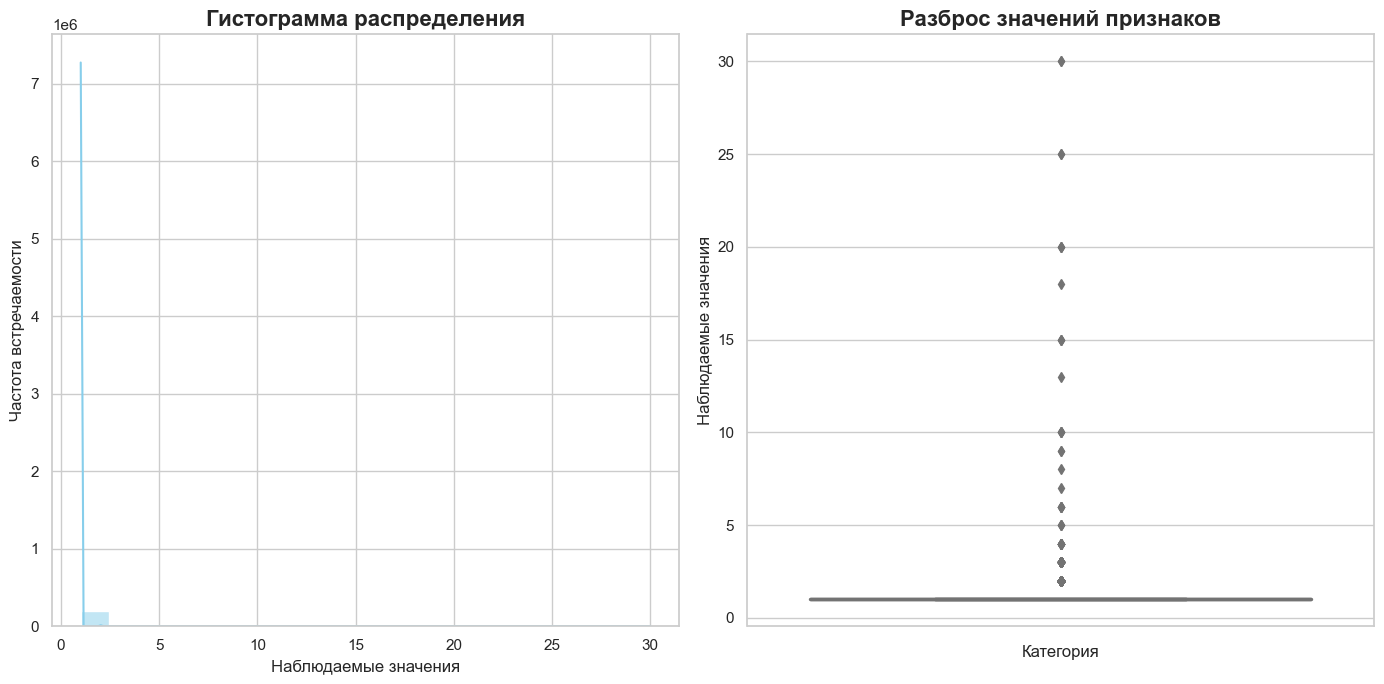

In [34]:
visualize_distribution(df_purchases, 'quantity')

Большенство людей совершило одну покупку. Максимальное число покупок - 30.

count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
max       85499.000000
Name: price, dtype: float64

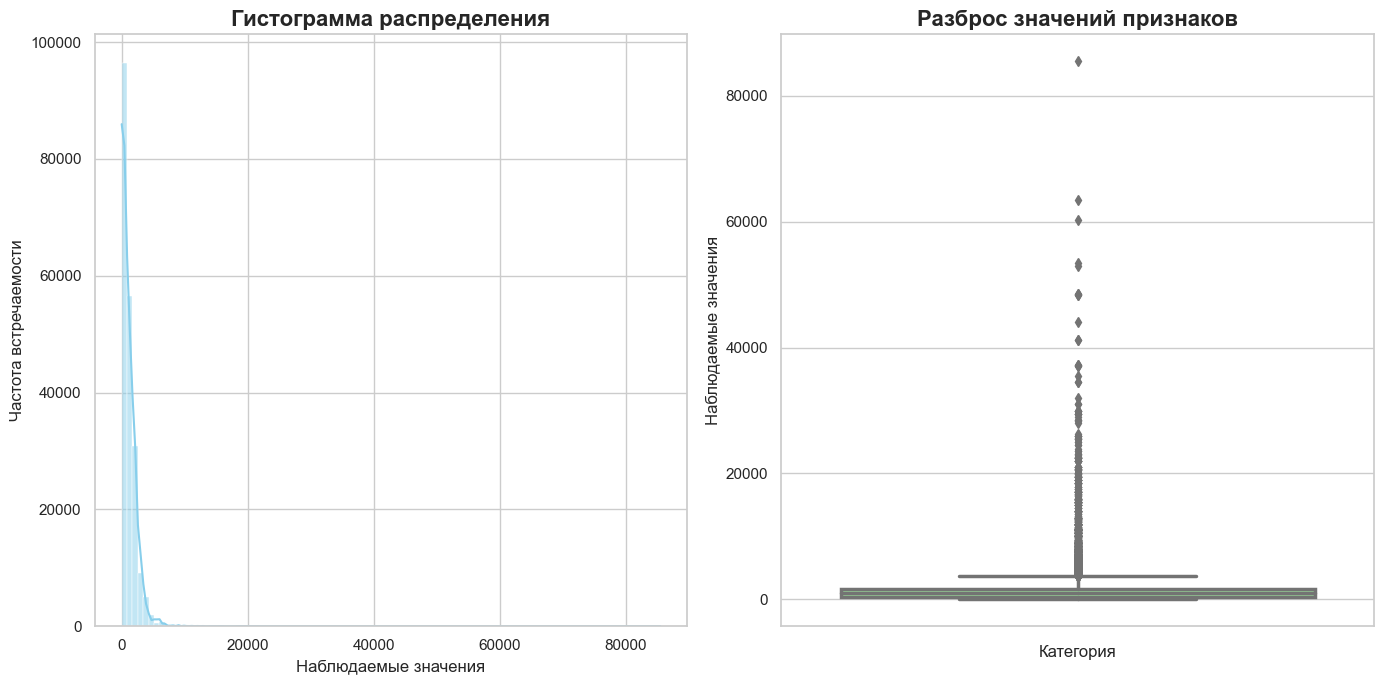

In [35]:
visualize_distribution(df_purchases, 'price', bins=100)

Минимальная цена покупки - 1, максимальная - 85499. Средняя цена покупки примерно составляет 1193.

Проверим топ 20 категорий товаров.

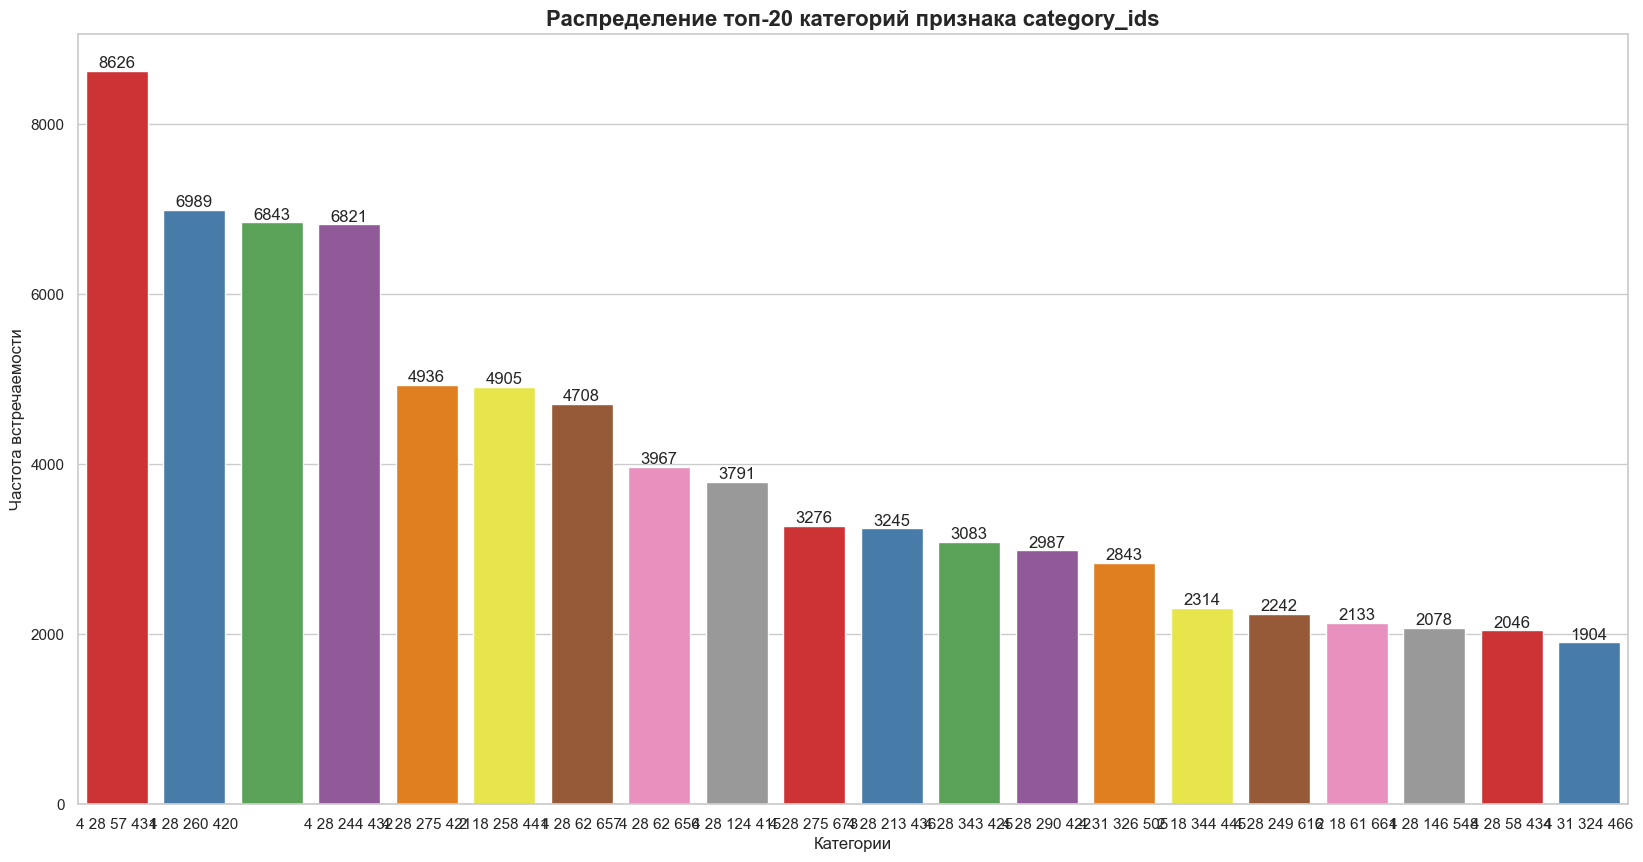

In [36]:
visualize_top_category_distribution(df_purchases, 'category_ids')

Видим что что в лидеры выбивается одна категория, затем идут три других примерно равных категории, а далее у категорий нет такого большого отрыва

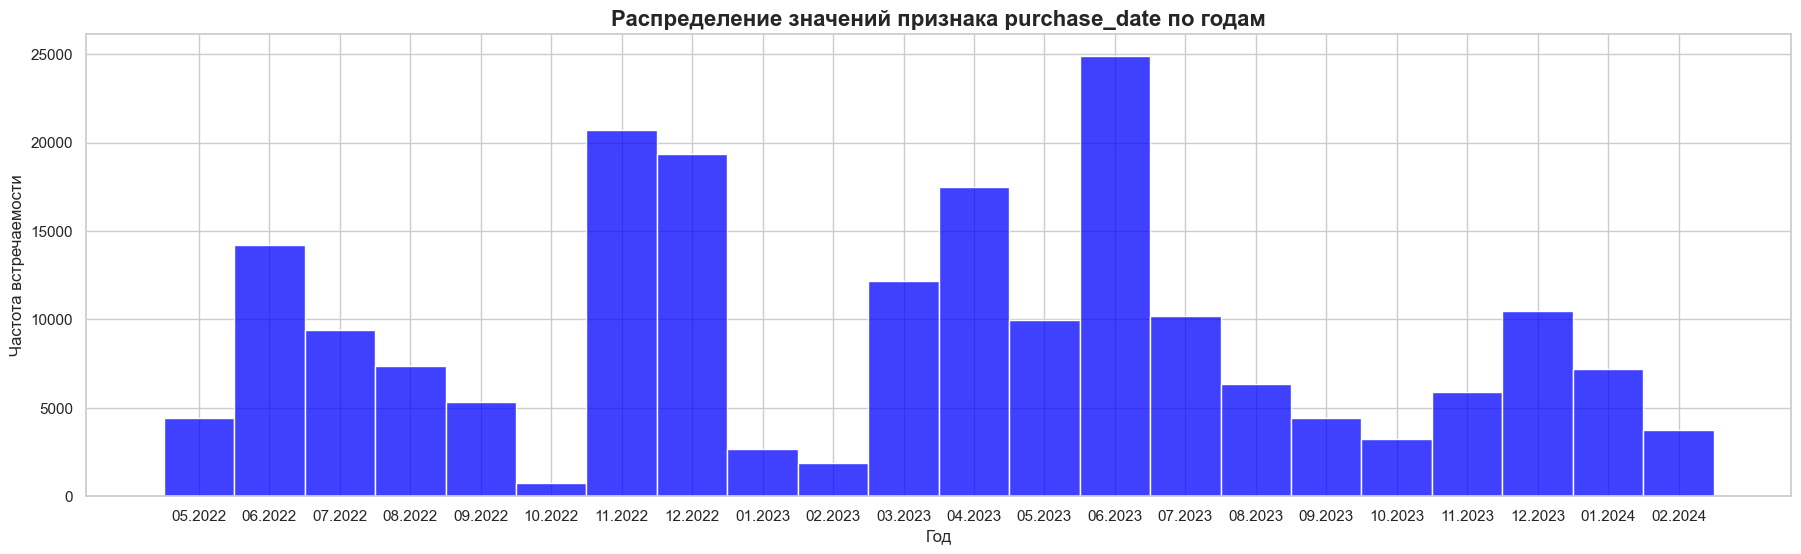

In [37]:
visualize_date_distribution(df_purchases, 'purchase_date')

Пики продаж идут летом и вконце года. Больше всего продаж было в 2023 году.

#### Исследование таблицы `df_messages`

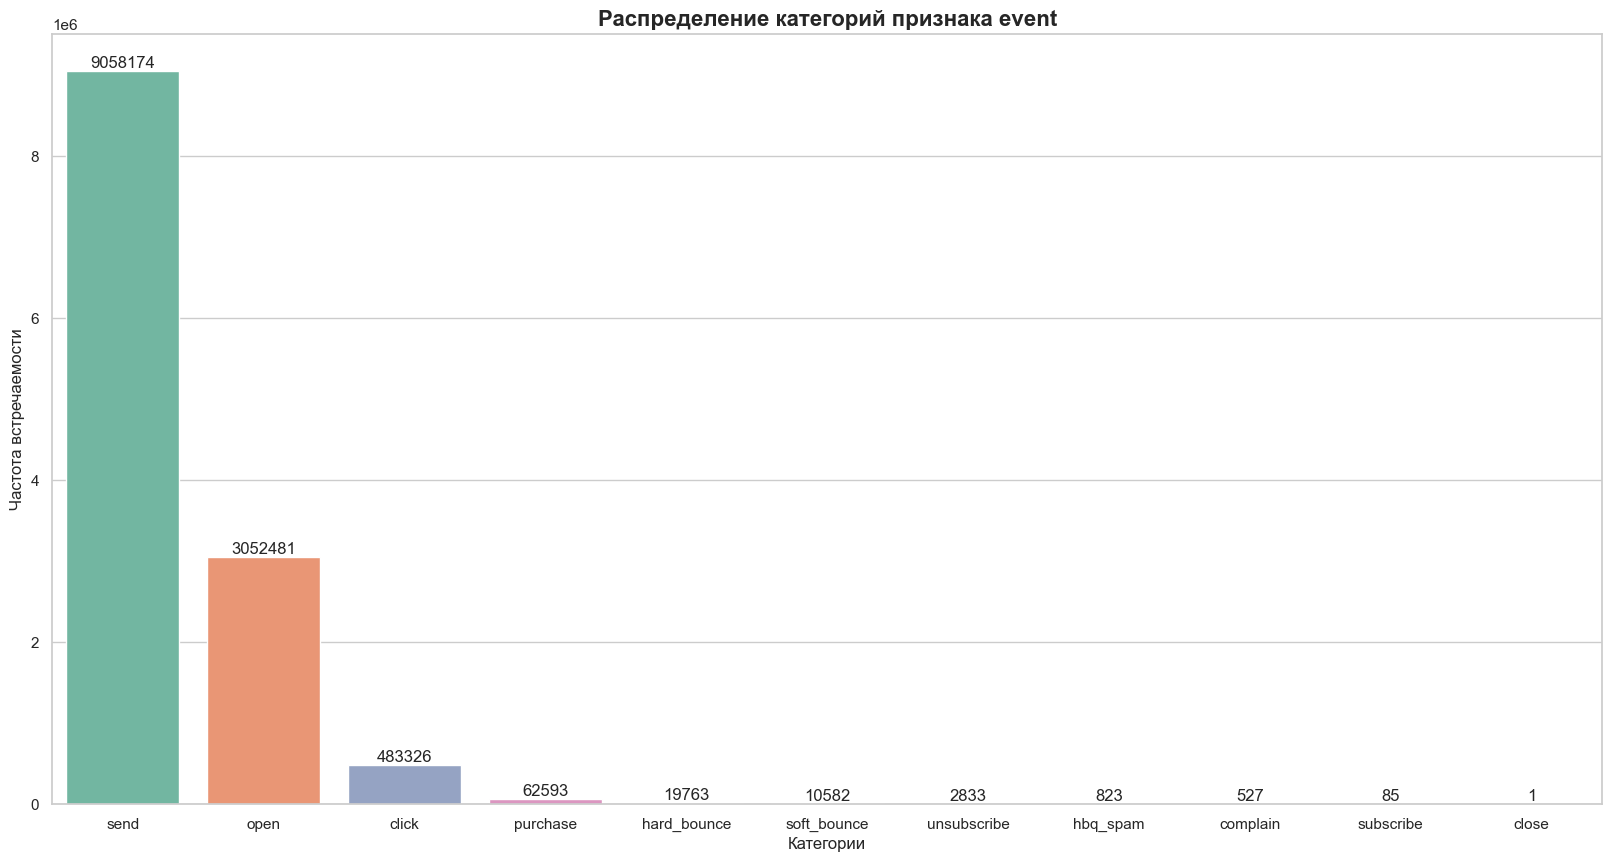

In [38]:
visualize_category_distribution(df_messages, 'event')

Больше всего встречает событие `send`, что ожидаемо. На втором и третем месте - `open` и `click`, что тоже логично. Примерное каждый третий пользователь, получивший сообщение открыл его, и примернко каждый шестой из открывших совершил покупку.

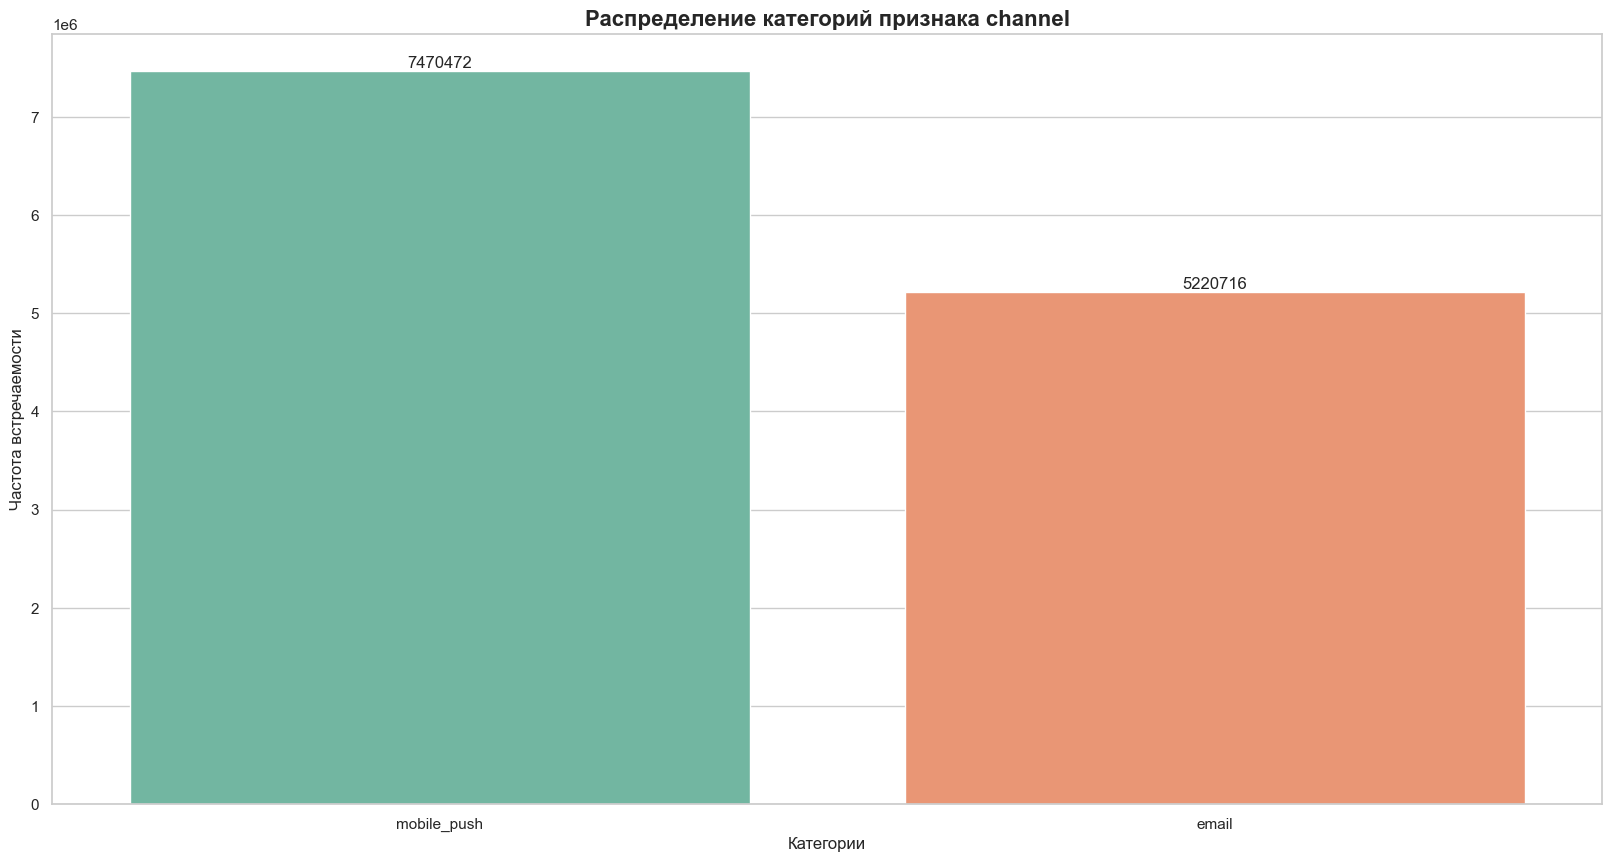

In [39]:
visualize_category_distribution(df_messages, 'channel')

59% пользователей получили пуш уведомление. 41% - email рассылку.

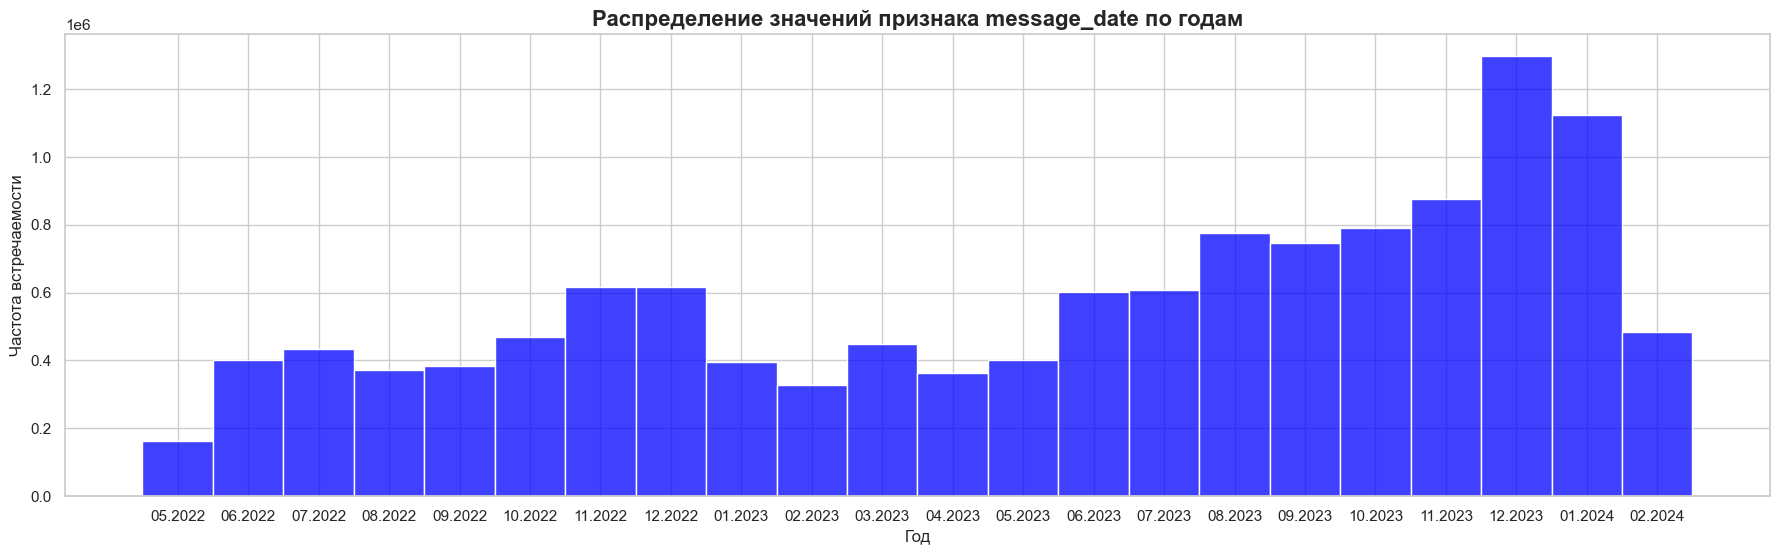

In [40]:
visualize_date_distribution(df_messages, 'message_date')

Видим, то что колличество рекламнох рассылок растет.

Посмотрим как накладываются временные ряды `purchase_date` из `df_purchases` и `message_date` из `df_messages`

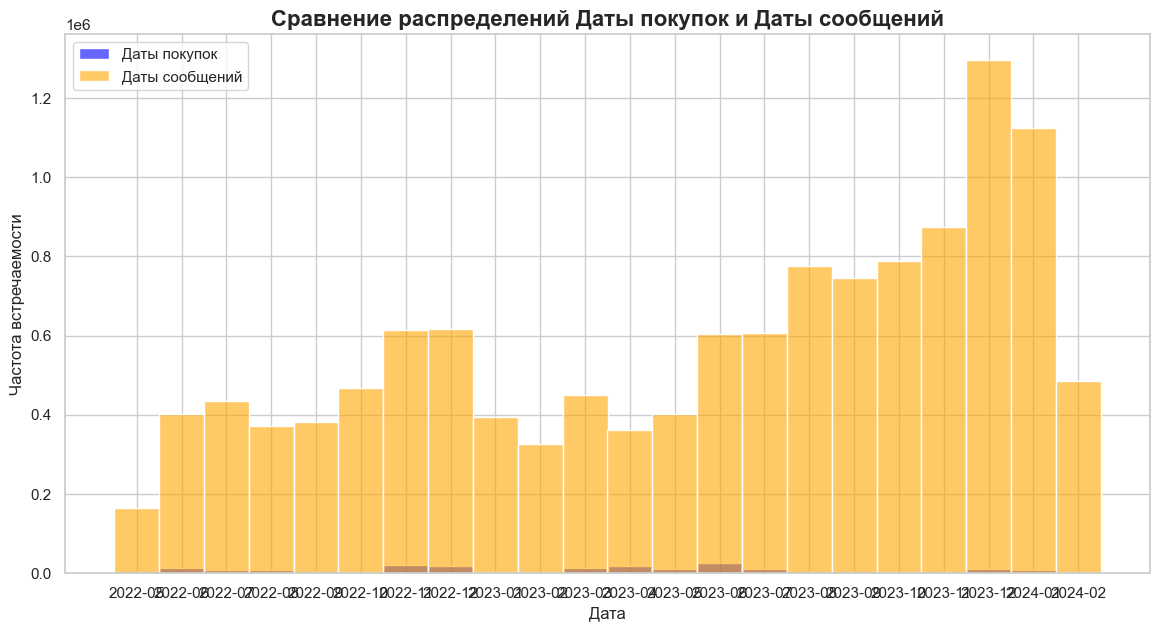

In [41]:
compare_date_distributions(df_purchases, 'purchase_date', df_messages, 'message_date', 
                           label1='Даты покупок', label2='Даты сообщений', 
                           date_format='%Y-%m', color1='blue', color2='orange')

Количество рекламных рассылко сильно преобладают над покупками. Но колличество рекламных сообщений начало расти, количество покупок в таком же проценте не увеличилось.

### Объединим датафреймы в один и создадим новые признаки.

Разделю значения в `df_purchases` в столбце `message_id`.

In [42]:
df_purchases[['client_id_str', 'bulk_campaign_id_extracted', 'message_hash']] = df_purchases['message_id'].str.split('-', expand=True)

df_purchases.drop(columns=['client_id_str', 'message_id'], inplace=True)

df_purchases['bulk_campaign_id_extracted'] = df_purchases['bulk_campaign_id_extracted'].astype(int)

df_purchases.head(10)

,client_id,quantity,price,category_ids,purchase_date,bulk_campaign_id_extracted,message_hash
0,1515915625468169594,1,1999.0,4 28 57 431,2022-05-16,4301,627b661e9736d
1,1515915625468169594,1,2499.0,4 28 57 431,2022-05-16,4301,627b661e9736d
2,1515915625471138230,1,6499.0,4 28 57 431,2022-05-16,4437,6282242f27843
3,1515915625471138230,1,4999.0,4 28 244 432,2022-05-16,4437,6282242f27843
4,1515915625471138230,1,4999.0,4 28 49 413,2022-05-16,4437,6282242f27843
5,1515915625471640575,1,3499.0,2 18 258 441,2022-05-16,4301,627b661b67ac3
6,1515915625490211585,1,1699.0,2 18 341 1311,2022-05-16,4301,627b661843283
7,1515915625490739153,1,1999.0,2 18 123 451,2022-05-16,4172,626b943cc789b
8,1515915625491478747,1,999.0,5562 5631 5549 667,2022-05-16,4273,6274ceb769d59
9,1515915625491651493,1,699.0,5562 5630 5649 678,2022-05-16,4437,6282242f2a9e2


Создам признаки сколько дней прошло с первой и последней покупки.

In [43]:
report_date = pd.Timestamp('2024-09-29')

df_last_purchase = df_purchases.groupby('client_id')['purchase_date'].max().reset_index()
df_last_purchase['last_purchase_date'] = (report_date - df_last_purchase['purchase_date']).dt.days

df_first_purchase = df_purchases.groupby('client_id')['purchase_date'].min().reset_index()
df_first_purchase['first_purchase_date'] = (report_date - df_first_purchase['purchase_date']).dt.days

df_purchases = pd.merge(df_purchases, df_last_purchase[['client_id', 'last_purchase_date']], on='client_id', how='left')
df_purchases = pd.merge(df_purchases, df_first_purchase[['client_id', 'first_purchase_date']], on='client_id', how='left')

df_purchases.head(10)

,client_id,quantity,price,category_ids,purchase_date,bulk_campaign_id_extracted,message_hash,last_purchase_date,first_purchase_date
0,1515915625468169594,1,1999.0,4 28 57 431,2022-05-16,4301,627b661e9736d,312,867
1,1515915625468169594,1,2499.0,4 28 57 431,2022-05-16,4301,627b661e9736d,312,867
2,1515915625471138230,1,6499.0,4 28 57 431,2022-05-16,4437,6282242f27843,867,867
3,1515915625471138230,1,4999.0,4 28 244 432,2022-05-16,4437,6282242f27843,867,867
4,1515915625471138230,1,4999.0,4 28 49 413,2022-05-16,4437,6282242f27843,867,867
5,1515915625471640575,1,3499.0,2 18 258 441,2022-05-16,4301,627b661b67ac3,835,867
6,1515915625490211585,1,1699.0,2 18 341 1311,2022-05-16,4301,627b661843283,867,867
7,1515915625490739153,1,1999.0,2 18 123 451,2022-05-16,4172,626b943cc789b,867,867
8,1515915625491478747,1,999.0,5562 5631 5549 667,2022-05-16,4273,6274ceb769d59,867,867
9,1515915625491651493,1,699.0,5562 5630 5649 678,2022-05-16,4437,6282242f2a9e2,867,867


In [44]:
df_purchases = df_purchases.sort_values('purchase_date')

df_purchases_agg = df_purchases.groupby('client_id').agg({
    'quantity': 'sum',
    'price': 'sum',
    'bulk_campaign_id_extracted': 'last',
    'last_purchase_date' : 'last',
    'first_purchase_date' : 'first'
}).reset_index()

df_purchases_agg.sample(3)

,client_id,quantity,price,bulk_campaign_id_extracted,last_purchase_date,first_purchase_date
10901,1515915625489390326,1,699.0,6289,751,751
7912,1515915625488331171,1,3999.0,5707,790,790
16394,1515915625491381863,2,4498.0,11760,534,534


Разделю значения в `df_messages` в столбце `message_id`.

In [45]:
df_messages[['client_id_str', 'bulk_campaign_id_extracted', 'message_hash']] = df_messages['message_id'].str.split('-', expand=True)

df_messages.drop(columns=['client_id_str', 'message_id'], inplace=True)

df_messages['bulk_campaign_id_extracted'] = df_messages['bulk_campaign_id_extracted'].astype(int)

df_messages.head(10)

,bulk_campaign_id,client_id,event,channel,message_date,created_at,bulk_campaign_id_extracted,message_hash
0,4439,1515915625626736623,open,email,2022-05-19,2022-05-19 00:14:20,4439,6283415ac07ea
1,4439,1515915625490086521,open,email,2022-05-19,2022-05-19 00:39:34,4439,62834150016dd
2,4439,1515915625553578558,open,email,2022-05-19,2022-05-19 00:51:49,4439,6283415b36b4f
3,4439,1515915625553578558,click,email,2022-05-19,2022-05-19 00:52:20,4439,6283415b36b4f
4,4439,1515915625471518311,open,email,2022-05-19,2022-05-19 00:56:52,4439,628341570c133
5,4439,1515915625594606468,open,email,2022-05-19,2022-05-19 01:04:11,4439,6283411f277fc
6,4439,1515915625491810918,open,email,2022-05-19,2022-05-19 01:19:54,4439,6283411d9d299
7,4439,1515915625474219766,open,email,2022-05-19,2022-05-19 01:23:43,4439,628341212233a
8,4439,1515915625474219766,click,email,2022-05-19,2022-05-19 01:24:16,4439,628341212233a
9,4439,1515915625566741491,open,email,2022-05-19,2022-05-19 01:31:06,4439,6283412871599


Объединим таблицы `df_messages` и `df_target_binary` по `client_id`.

In [46]:
df = pd.merge(df_messages, df_target_binary, on='client_id', how='right')
df.head(10)

,bulk_campaign_id,client_id,event,channel,message_date,created_at,bulk_campaign_id_extracted,message_hash,target
0,4463.0,1515915625468060902,send,email,2022-05-19,2022-05-19 06:32:28,4463.0,6285e404c62b9,0
1,4568.0,1515915625468060902,send,email,2022-05-25,2022-05-25 07:43:38,4568.0,628ddb1f311b5,0
2,4591.0,1515915625468060902,send,email,2022-05-26,2022-05-26 06:31:29,4591.0,628f1e7ee9206,0
3,4617.0,1515915625468060902,send,email,2022-05-27,2022-05-27 05:49:50,4617.0,6290657dac196,0
4,4617.0,1515915625468060902,open,email,2022-05-27,2022-05-27 10:57:52,4617.0,6290657dac196,0
5,4617.0,1515915625468060902,click,email,2022-05-27,2022-05-27 10:59:04,4617.0,6290657dac196,0
6,4617.0,1515915625468060902,click,email,2022-05-27,2022-05-27 11:22:53,4617.0,6290657dac196,0
7,4617.0,1515915625468060902,purchase,email,2022-05-27,2022-05-27 11:26:49,4617.0,6290657dac196,0
8,4617.0,1515915625468060902,purchase,email,2022-05-27,2022-05-27 11:31:31,4617.0,6290657dac196,0
9,4617.0,1515915625468060902,click,email,2022-05-27,2022-05-27 11:35:07,4617.0,6290657dac196,0


In [47]:
unique_client_count = df['client_id'].nunique()
print(f"Количество уникальных client_id в df: {unique_client_count}")

Количество уникальных client_id в df: 49849


In [48]:
df['event'].unique()

array(['send', 'open', 'click', 'purchase', 'unsubscribe', 'hard_bounce',
       'soft_bounce', 'hbq_spam', 'complain', nan, 'subscribe', 'close'],
      dtype=object)

In [49]:
category_map = {
    'open': 'good',
    'click': 'good',
    'purchase': 'good',
    'subscribe': 'good',
    'unsubscribe': 'bad',
    'complain': 'bad'
}

df['category_event'] = df['event'].map(category_map).fillna('other')

Используем `OneHotEncoder` для категориальных признаков.

In [50]:
encoder = OneHotEncoder(sparse_output=False)

df = df.reset_index(drop=True)

encoded_data = encoder.fit_transform(df[['event',
                                         'channel',
                                         'category_event']])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

df = pd.concat([df, encoded_df], axis=1)

In [51]:
# Удалю данные, которые уже не используются, так как не хватает памяти
del df_purchases
del df_messages
del df_target_binary
del encoded_data

Группировка таблицы по `client_id`.

In [52]:
df = df.sort_values('message_date')

df_agg = \
df.groupby('client_id').agg({'bulk_campaign_id' : 'last',
                                                 'target' : 'first',
                                                 'event_click' : 'sum',
                                                 'event_close' : 'sum',
                                                 'event_complain' : 'sum',
                                                 'event_hard_bounce' : 'sum',
                                                 'event_hbq_spam' : 'sum',
                                                 'event_open' : 'sum',
                                                 'event_purchase' : 'sum',
                                                 'event_send' : 'sum',
                                                 'event_soft_bounce' : 'sum',
                                                 'event_subscribe' : 'sum',
                                                 'event_unsubscribe' : 'sum',
                                                 'channel_email' : 'sum',
                                                 'channel_mobile_push' : 'sum',
                                                 'category_event_bad' : 'sum',
                                                 'category_event_good' : 'sum',
                                                 'category_event_other' : 'sum'
                                                 }).reset_index()

In [53]:
# Удалю данные, которые уже не используются, так как не хватает памяти
del df

Объеденим данные в финальный датафрейм

In [54]:
df = df_agg.merge(df_purchases_agg, on='client_id', how='left')

In [55]:
# Удалю данные, которые уже не используются, так как не хватает памяти
del df_agg
del df_purchases_agg

In [56]:
df.isna().sum()

client_id                        0
bulk_campaign_id              7867
target                           0
event_click                      0
event_close                      0
event_complain                   0
event_hard_bounce                0
event_hbq_spam                   0
event_open                       0
event_purchase                   0
event_send                       0
event_soft_bounce                0
event_subscribe                  0
event_unsubscribe                0
channel_email                    0
channel_mobile_push              0
category_event_bad               0
category_event_good              0
category_event_other             0
quantity                         0
price                            0
bulk_campaign_id_extracted       0
last_purchase_date               0
first_purchase_date              0
dtype: int64

Заполню пропущенные значения заглушкой

In [57]:
df['bulk_campaign_id'] = df['bulk_campaign_id'].fillna(-999)
df['bulk_campaign_id'] = df['bulk_campaign_id'].astype(int)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   client_id                   49849 non-null  int64  
 1   bulk_campaign_id            49849 non-null  int32  
 2   target                      49849 non-null  int64  
 3   event_click                 49849 non-null  float64
 4   event_close                 49849 non-null  float64
 5   event_complain              49849 non-null  float64
 6   event_hard_bounce           49849 non-null  float64
 7   event_hbq_spam              49849 non-null  float64
 8   event_open                  49849 non-null  float64
 9   event_purchase              49849 non-null  float64
 10  event_send                  49849 non-null  float64
 11  event_soft_bounce           49849 non-null  float64
 12  event_subscribe             49849 non-null  float64
 13  event_unsubscribe           498

In [59]:
df.isna().sum()

client_id                     0
bulk_campaign_id              0
target                        0
event_click                   0
event_close                   0
event_complain                0
event_hard_bounce             0
event_hbq_spam                0
event_open                    0
event_purchase                0
event_send                    0
event_soft_bounce             0
event_subscribe               0
event_unsubscribe             0
channel_email                 0
channel_mobile_push           0
category_event_bad            0
category_event_good           0
category_event_other          0
quantity                      0
price                         0
bulk_campaign_id_extracted    0
last_purchase_date            0
first_purchase_date           0
dtype: int64

### Вывод

- Создал новые признаки - в которые вошли данные о количестве дней с момента первой и последней покупки
- Объединил события в три категории
- Были объеденены таблицы в один датафрейм

Столбец channel_email имеет 488 уникальных значений. Пропускаем бининг.
Столбец channel_mobile_push имеет 665 уникальных значений. Пропускаем бининг.
Столбец category_event_bad имеет 12 уникальных значений. Пропускаем бининг.
Столбец category_event_good имеет 437 уникальных значений. Пропускаем бининг.
Столбец category_event_other имеет 537 уникальных значений. Пропускаем бининг.
Столбец quantity имеет 90 уникальных значений. Пропускаем бининг.
Столбец price имеет 9622 уникальных значений. Выполняется бининг.
Столбец last_purchase_date имеет 639 уникальных значений. Пропускаем бининг.
Столбец first_purchase_date имеет 640 уникальных значений. Пропускаем бининг.


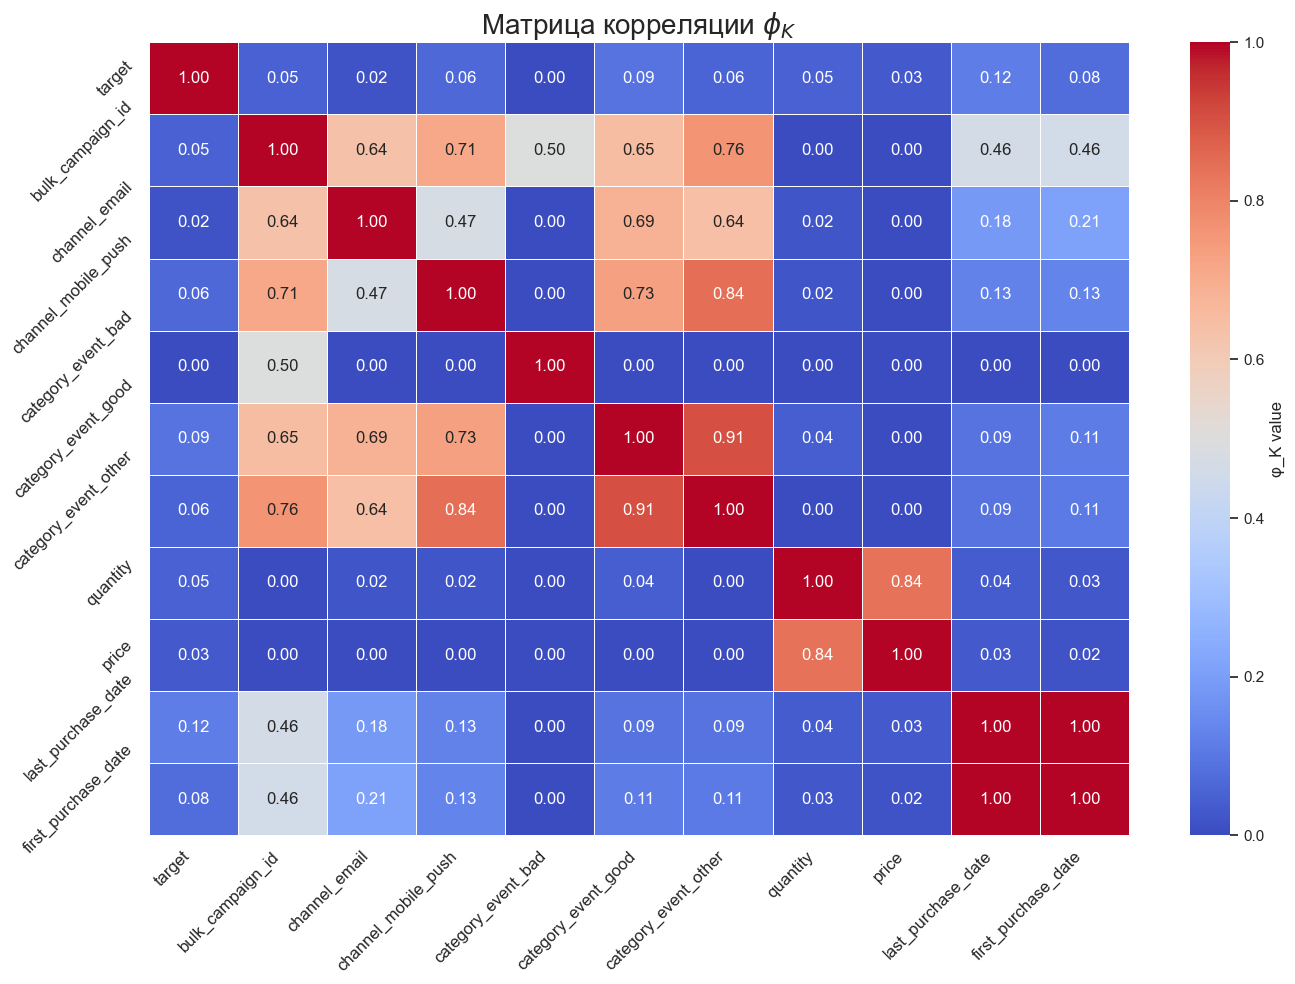

In [60]:
interval_columns = [
    'channel_email',
    'channel_mobile_push',
    'category_event_bad',
    'category_event_good',
    'category_event_other',
    'quantity',
    'price',
    'last_purchase_date',
    'first_purchase_date'
]

for col in interval_columns:
    unique_values = df[col].nunique()
    if unique_values > 1000:
        print(f"Столбец {col} имеет {unique_values} уникальных значений. Выполняется бининг.")
        df[col] = pd.cut(df[col], bins=50)
    else:
        print(f"Столбец {col} имеет {unique_values} уникальных значений. Пропускаем бининг.")

for col in interval_columns:
    if pd.api.types.is_categorical_dtype(df[col]):
        df[col] = df[col].apply(lambda x: x.mid if pd.notna(x) else np.nan)

try:
    phik_matrix = df[[
        'target',
        'bulk_campaign_id',
        'channel_email',
        'channel_mobile_push',
        'category_event_bad',
        'category_event_good',
        'category_event_other',
        'quantity',
        'price',
        'last_purchase_date',
        'first_purchase_date'
    ]].phik_matrix(interval_cols=interval_columns)

    plt.figure(figsize=(14, 10))
    sns.heatmap(
        phik_matrix.values, 
        annot=True,         
        cmap='coolwarm',    
        linewidths=0.5,     
        cbar_kws={'label': 'φ_K value'},
        fmt='.2f'
    )

    plt.title(r"Матрица корреляции $\phi_K$", fontsize=20)
    plt.xticks(ticks=np.arange(len(phik_matrix.columns)) + 0.5, labels=phik_matrix.columns, rotation=45, ha='right', fontsize=12)
    plt.yticks(ticks=np.arange(len(phik_matrix.index)) + 0.5, labels=phik_matrix.index, rotation=45,fontsize=12)
    plt.tight_layout()

    plt.show()

except ValueError as e:
    print(f"Ошибка при расчете phi_K матрицы: {e}")

Лучше всего целевой признак коррелирует с `bulk_campaign_id`, `channel_mobile_push`, `category_event_good`, `category_event_other`, `quantity`, `last_purchase_date`. Хуже всего с `category_event_bad`.

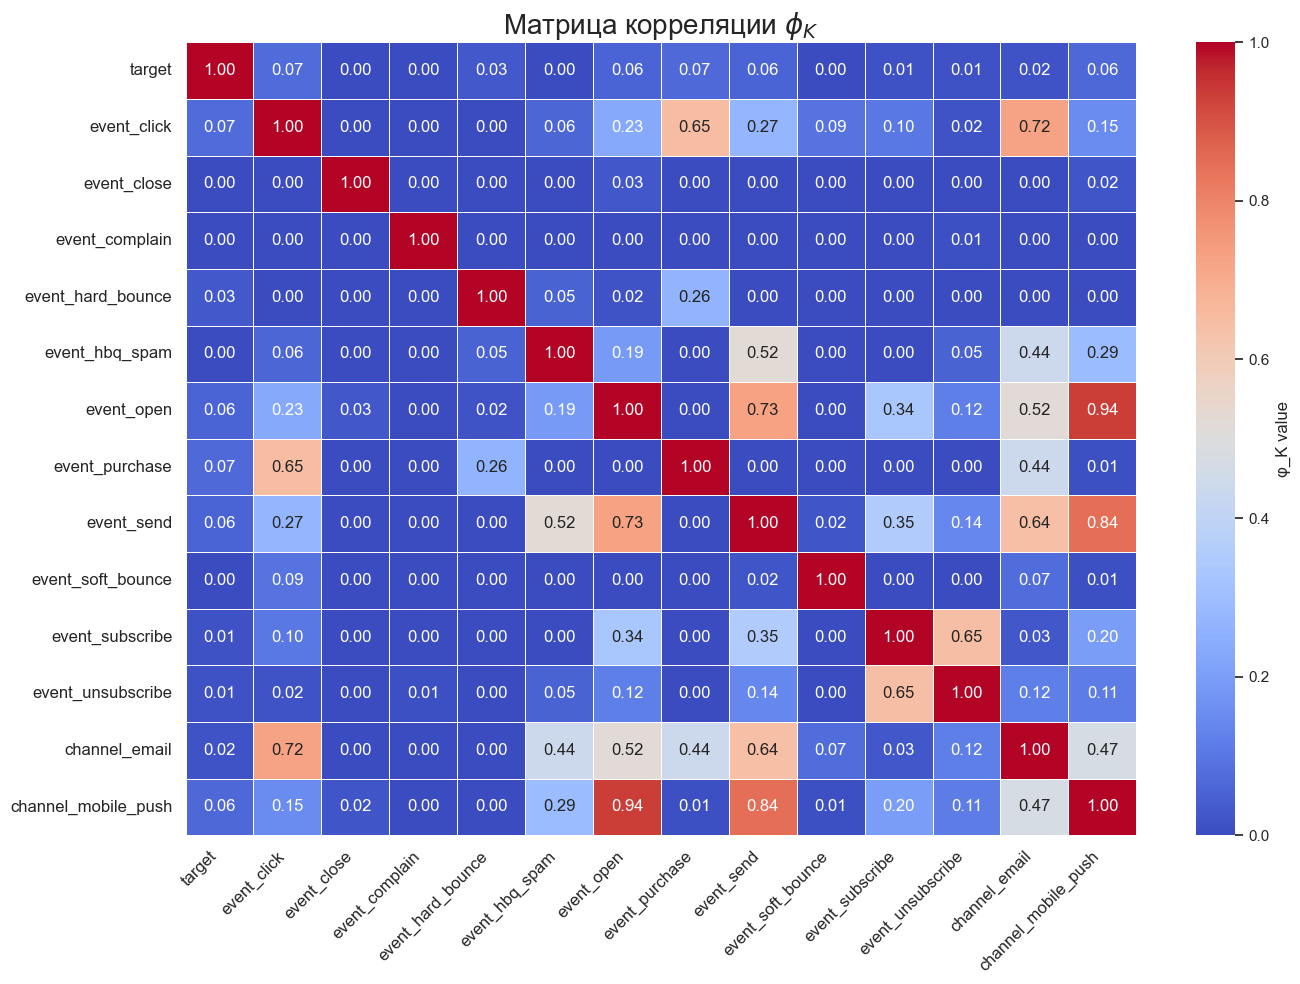

In [61]:
interval_columns_2 = [
    'event_click',
    'event_close',
    'event_complain',
    'event_hard_bounce',
    'event_hbq_spam',
    'event_open',
    'event_purchase',
    'event_send',
    'event_soft_bounce',
    'event_subscribe',
    'event_unsubscribe',
    'channel_email',
    'channel_mobile_push'
]

phik_matrix = df[[
    'target',
    'event_click',
    'event_close',
    'event_complain',
    'event_hard_bounce',
    'event_hbq_spam',
    'event_open',
    'event_purchase',
    'event_send',
    'event_soft_bounce',
    'event_subscribe',
    'event_unsubscribe',
    'channel_email',
    'channel_mobile_push'
]].phik_matrix(interval_cols=interval_columns_2)

plt.figure(figsize=(14, 10))
sns.heatmap(
    phik_matrix.values, 
    annot=True,         
    cmap='coolwarm',    
    linewidths=0.5,     
    cbar_kws={'label': 'φ_K value'},
    fmt='.2f'
)

plt.title(r"Матрица корреляции $\phi_K$", fontsize=20)
plt.xticks(ticks=np.arange(len(phik_matrix.columns)) + 0.5, labels=phik_matrix.columns, rotation=45, ha='right', fontsize=12)
plt.yticks(ticks=np.arange(len(phik_matrix.index)) + 0.5, labels=phik_matrix.index, rotation=0, fontsize=12)
plt.tight_layout()

plt.show()

In [62]:
df.head(10)

,client_id,bulk_campaign_id,target,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,...,channel_email,channel_mobile_push,category_event_bad,category_event_good,category_event_other,quantity,price,bulk_campaign_id_extracted,last_purchase_date,first_purchase_date
0,1515915625468060902,14502,0,10.0,0.0,0.0,0.0,0.0,35.0,5.0,...,177.0,0.0,1.0,50.0,126.0,7,5134.8665,4617,856,856
1,1515915625468061003,14624,1,5.0,0.0,0.0,0.0,0.0,5.0,1.0,...,165.0,0.0,0.0,11.0,154.0,7,16213.2100,9148,634,634
2,1515915625468061099,14641,0,8.0,0.0,0.0,2.0,0.0,51.0,0.0,...,182.0,94.0,0.0,59.0,217.0,1,5134.8665,4439,866,866
3,1515915625468061100,14648,0,1.0,0.0,0.0,1.0,0.0,157.0,1.0,...,0.0,428.0,0.0,159.0,269.0,2,5134.8665,14623,232,232
4,1515915625468061170,14648,0,16.0,0.0,0.0,0.0,0.0,31.0,3.0,...,202.0,91.0,0.0,50.0,243.0,19,37829.4900,13157,470,553
5,1515915625468061514,14641,0,12.0,0.0,0.0,0.0,0.0,17.0,1.0,...,180.0,0.0,0.0,30.0,150.0,1,5134.8665,5707,792,792
6,1515915625468061877,14648,0,5.0,0.0,0.0,0.0,0.0,50.0,1.0,...,67.0,162.0,0.0,56.0,173.0,1,5134.8665,5922,772,772
7,1515915625468061975,14641,0,7.0,0.0,0.0,0.0,1.0,17.0,1.0,...,180.0,0.0,0.0,25.0,155.0,1,5134.8665,5662,795,795
8,1515915625468061994,14649,0,9.0,0.0,0.0,0.0,0.0,21.0,2.0,...,96.0,282.0,0.0,32.0,346.0,8,5134.8665,8663,655,684
9,1515915625468062158,14641,0,29.0,0.0,0.0,0.0,0.0,28.0,2.0,...,172.0,0.0,0.0,59.0,113.0,4,5134.8665,12218,520,860


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   client_id                   49849 non-null  int64   
 1   bulk_campaign_id            49849 non-null  int32   
 2   target                      49849 non-null  int64   
 3   event_click                 49849 non-null  float64 
 4   event_close                 49849 non-null  float64 
 5   event_complain              49849 non-null  float64 
 6   event_hard_bounce           49849 non-null  float64 
 7   event_hbq_spam              49849 non-null  float64 
 8   event_open                  49849 non-null  float64 
 9   event_purchase              49849 non-null  float64 
 10  event_send                  49849 non-null  float64 
 11  event_soft_bounce           49849 non-null  float64 
 12  event_subscribe             49849 non-null  float64 
 13  event_unsubscrib

Лучше всего целевой признак коррелирует с `event_click`, `event_open`, `event_purchase`, `event_send`, `channel_mobile_push`.

In [64]:
data = df[['client_id',
               'target',
               'event_click',
               'event_open',
               'event_purchase',
               'channel_mobile_push',
               'category_event_good',
               'quantity',
               'price',
               'bulk_campaign_id',
               'event_hard_bounce',
               'last_purchase_date'
               ]]

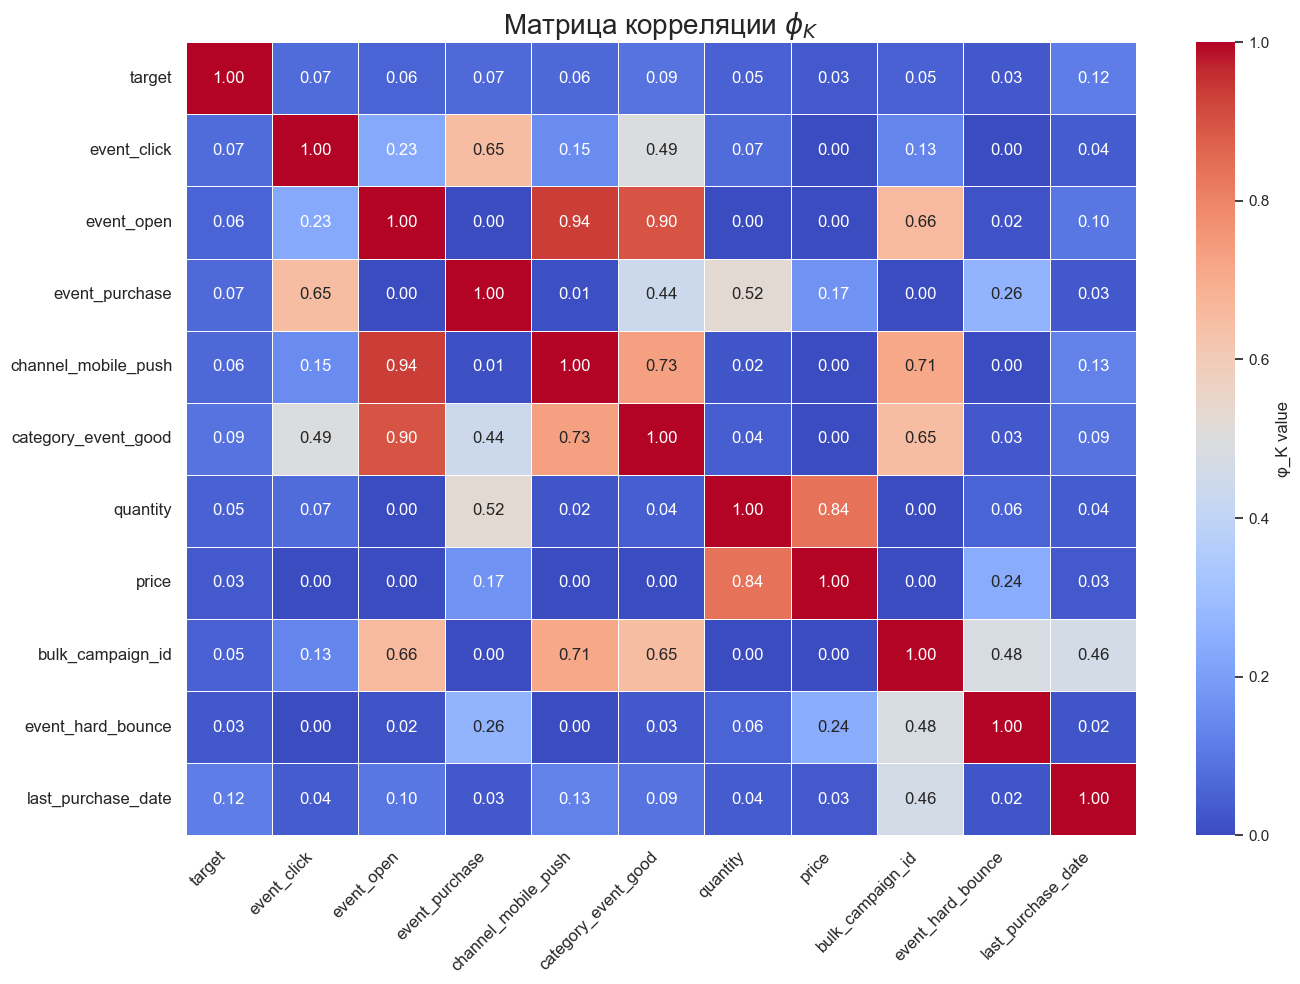

In [65]:
interval_columns_3 = data.drop(['client_id',
                                'bulk_campaign_id'
                          ], axis=1).columns.tolist()

phik_matrix = data.drop(['client_id',], axis=1).phik_matrix(interval_cols=interval_columns_3)

plt.figure(figsize=(14, 10))
sns.heatmap(
    phik_matrix.values, 
    annot=True,         
    cmap='coolwarm',    
    linewidths=0.5,     
    cbar_kws={'label': 'φ_K value'},
    fmt='.2f'
)

plt.title(r"Матрица корреляции $\phi_K$", fontsize=20)
plt.xticks(ticks=np.arange(len(phik_matrix.columns)) + 0.5, labels=phik_matrix.columns, rotation=45, ha='right', fontsize=12)
plt.yticks(ticks=np.arange(len(phik_matrix.index)) + 0.5, labels=phik_matrix.index, rotation=0, fontsize=12)
plt.tight_layout()

plt.show()

### Вывод

Собрал новый датафрейм с наиболее корелирующими признаками, такими как:
- 'event_click'
- 'event_open'
- 'event_purchase'
- 'channel_mobile_push'
- 'category_event_good'
- 'quantity'
- 'price'
- 'event_hard_bounce'
- 'last_purchase_date'

### Подготовка данных

Разделение данных на обучающую и тестовую выборки

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['client_id', 'target'], axis=1),
    data['target'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=data['target']
)

Получаем список числовых признаков

In [67]:
numeric_features = X_train.drop(['bulk_campaign_id'], axis=1).select_dtypes(include='number').columns.tolist()

Определяем признаки для OrdinalEncoder

In [68]:
ordinal_features = ['bulk_campaign_id']

Пайплайн для работы с категориальными признаками

In [69]:
ordinal_pipeline = Pipeline(
    steps=[
        ('impute_missing_before', SimpleImputer(strategy='constant', fill_value=-999)),
        ('ordinal_encoding', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('impute_missing_after', SimpleImputer(strategy='constant', fill_value=-999))
    ]
)

Пайплайн для предобработки данных

In [70]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_pipeline, ordinal_features),
        ('numeric', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

Определим гиперпараметры для поиска

Logistic Regression

In [71]:
param_grid_lr = {
    'classifier__C': np.logspace(-3, 3, 10),
    'classifier__solver': ['liblinear', 'lbfgs']
}

Random Forest

In [72]:
param_grid_rf = {
    'classifier__n_estimators': np.arange(50, 300, 50),
    'classifier__max_depth': np.arange(3, 20, 2),
    'classifier__min_samples_split': np.arange(2, 20, 2),
    'classifier__min_samples_leaf': np.arange(1, 10, 1)
}

LightGBM

In [73]:
param_grid_lgbm = {
    'classifier__n_estimators': np.arange(50, 300, 50),
    'classifier__learning_rate': np.logspace(-3, 0, 10),
    'classifier__num_leaves': np.arange(20, 150, 10),
    'classifier__max_depth': np.arange(3, 20, 2)
}

K-Neighbors

In [74]:
param_grid_knn = {
    'classifier__n_neighbors': np.arange(1, 50, 2),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

Словарь моделей и их гиперпараметров

In [75]:
models = {
    'Logistic Regression': (LogisticRegression(random_state=RANDOM_STATE), param_grid_lr),
    'Random Forest': (RandomForestClassifier(random_state=RANDOM_STATE), param_grid_rf),
    'LGBM': (LGBMClassifier(random_state=RANDOM_STATE), param_grid_lgbm),
    'KNeighbors': (KNeighborsClassifier(), param_grid_knn)
}

Цикл по моделям для их настройки и оценки

In [76]:
for model_name, (model, param_grid) in models.items():
    final_pipeline = Pipeline(
        steps=[
            ('preprocessing', preprocessor),
            ('classifier', model)
        ]
    )
    
    random_search = RandomizedSearchCV(
        final_pipeline, 
        param_grid, 
        n_iter=20,
        scoring='roc_auc',
        cv=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)
    
    print(f"Best params for {model_name}: {random_search.best_params_}")
    print(f"Best ROC AUC for {model_name}: {random_search.best_score_:.4f}")

Best params for Logistic Regression: {'classifier__solver': 'liblinear', 'classifier__C': 215.44346900318823}
Best ROC AUC for Logistic Regression: 0.7104
Best params for Random Forest: {'classifier__n_estimators': 150, 'classifier__min_samples_split': 18, 'classifier__min_samples_leaf': 6, 'classifier__max_depth': 9}
Best ROC AUC for Random Forest: 0.7361
[LightGBM] [Info] Number of positive: 721, number of negative: 36665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 37386, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019285 -> initscore=-3.928939
[LightGBM] [Info] Start training from score -3.928939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Создаем пайплайн с лучшими гиперпараметрами для LGBMClassifier

In [77]:
best_lgbm_pipeline = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classifier', LGBMClassifier(
            num_leaves=140, 
            n_estimators=200, 
            max_depth=3, 
            learning_rate=0.021544346900318832,
            random_state=RANDOM_STATE
        ))
    ]
)

Обучаем модель на тренировочных данных

In [78]:
best_lgbm_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 721, number of negative: 36665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 37386, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019285 -> initscore=-3.928939
[LightGBM] [Info] Start training from score -3.928939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  Pipeline(steps=[('impute_missing_before',
                                                                   SimpleImputer(fill_value=-999,
                                                                                 strategy='constant')),
                                                                  ('ordinal_encoding',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('impute_missing_after',
                                                                   SimpleImputer(fill_value=-999,
                                                                                 strategy='constant'))]),
                                                  ['bulk_campaign_id']),
                                                 ('numeric', StandardScaler(),
                                                  ['event_click', 'event_open',
                                                   'event_purchase',
                                                   'channel_mobile_push',
                                                   'category_event_good',
                                                   'quantity',
                                                   'event_hard_bounce',
                                                   'last_purchase_date'])])),
                ('classifier',
                 LGBMClassifier(learning_rate=0.021544346900318832, max_depth=3,
                                n_estimators=200, num_leaves=140,
                                random_state=42))])

Предсказания вероятностей на тестовой выборке

In [79]:
y_pred_proba = best_lgbm_pipeline.predict_proba(X_test)[:, 1]

Вычисление ROC AUC на тестовой выборке

In [80]:
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC AUC on the test set: {roc_auc:.4f}")

ROC AUC on the test set: 0.7527


### Вывод

Модели и результаты на кросс-валидации:

Logistic Regression:
- Лучшие гиперпараметры: {'classifier__solver': 'liblinear', 'classifier__C': 215.44346900318823}
- Средний ROC AUC на кросс-валидации: 0.7104


Random Forest:
- Лучшие гиперпараметры: {'classifier__n_estimators': 150, 'classifier__min_samples_split': 18, 'classifier__min_samples_leaf': 6, 'classifier__max_depth': 9}
- Средний ROC AUC на кросс-валидации: 0.7361


LGBM (LightGBM):
- Лучшие гиперпараметры: {'classifier__num_leaves': 140, 'classifier__n_estimators': 200, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.021544346900318832}
- Средний ROC AUC на кросс-валидации: 0.7368


KNeighbors (KNN):
- Лучшие гиперпараметры: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 45, 'classifier__metric': 'euclidean'}
- Средний ROC AUC на кросс-валидации: 0.6513


Финальная модель:
Лучшие результаты на кросс-валидации показала модель LightGBM с ROC AUC 0.7368. Мы обучили модель на всей обучающей выборке с найденными гиперпараметрами и проверили её на тестовой выборке.

Результат модели LightGBM на тестовой выборке:
- ROC AUC: 0.7527

### Анализ важности признаков

Обучаем модель LGBM с лучшими гиперпараметрами, если это не было сделано

In [81]:
best_lgbm_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 721, number of negative: 36665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 37386, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019285 -> initscore=-3.928939
[LightGBM] [Info] Start training from score -3.928939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  Pipeline(steps=[('impute_missing_before',
                                                                   SimpleImputer(fill_value=-999,
                                                                                 strategy='constant')),
                                                                  ('ordinal_encoding',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('impute_missing_after',
                                                                   SimpleImputer(fill_value=-999,
                                                                                 strategy='constant'))]),
                                                  ['bulk_campaign_id']),
                                                 ('numeric', StandardScaler(),
                                                  ['event_click', 'event_open',
                                                   'event_purchase',
                                                   'channel_mobile_push',
                                                   'category_event_good',
                                                   'quantity',
                                                   'event_hard_bounce',
                                                   'last_purchase_date'])])),
                ('classifier',
                 LGBMClassifier(learning_rate=0.021544346900318832, max_depth=3,
                                n_estimators=200, num_leaves=140,
                                random_state=42))])

Получаем имена признаков после предобработки

In [82]:
feature_names = numeric_features + ordinal_features

Извлекаем важности признаков из модели LightGBM

In [83]:
importances = best_lgbm_pipeline.named_steps['classifier'].feature_importances_

Получаем имена всех признаков после применения ColumnTransformer

In [84]:
feature_names_out = best_lgbm_pipeline.named_steps['preprocessing'].get_feature_names_out()

Проверяем длину массива признаков и важностей

In [85]:
print(f"Number of features: {len(feature_names_out)}")
print(f"Number of importances: {len(importances)}")

Number of features: 10
Number of importances: 10


Создаем DataFrame для визуализации важности признаков

In [86]:
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_out,
    'Importance': importances
})

Сортируем признаки по важности

In [87]:
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

Построение графика

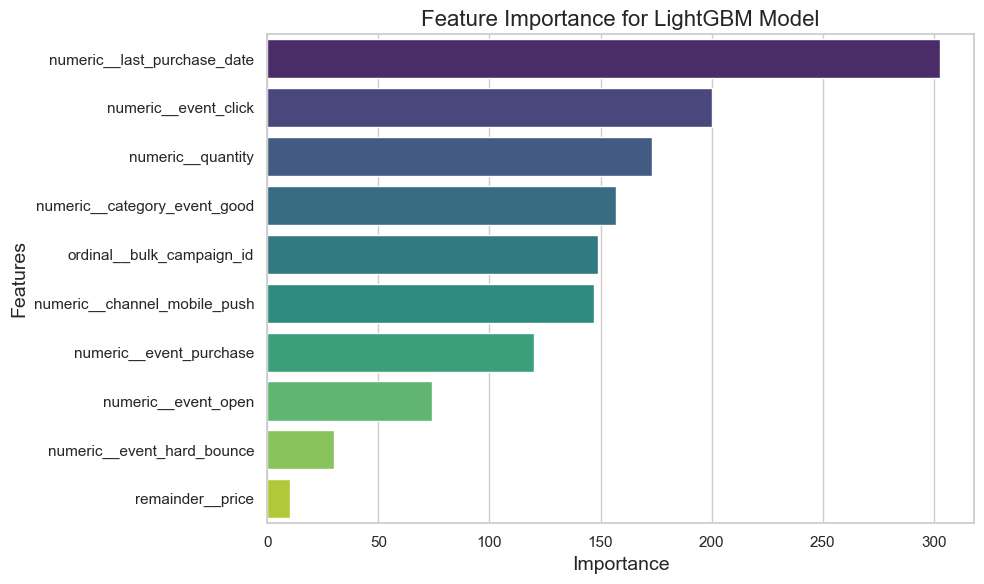

In [88]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')
plt.title('Feature Importance for LightGBM Model', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

Наиболее важным признаком с отрывом оказался `last_purchase_date`. Наименее важным признаком является `price`.

# Исследование активности клиентов интернет-магазина

### Цель исследования:
Целью данного исследования является построение модели машинного обучения для предсказания будущей активности клиентов: совершит ли клиент покупку в течение 90 дней. Для решения задачи был предоставлен набор данных о покупках клиентов и маркетинговой активности.

### Обзор данных:
1. **Таблица df_purchases:** содержит данные о покупках клиентов по дням и товарам. 
   - Количество строк: 202,208
   - Пропущенных значений нет.
   
2. **Таблица df_messages:** содержит информацию о рассылках, отправленных клиентам.
   - Количество строк: 12,739,798
   - Пропущенных значений нет.
   
3. **Таблица df_target_binary:** содержит целевой признак — совершит ли клиент покупку в течение 90 дней.
   - Количество строк: 49,849
   - Пропущенных значений нет.

### Предобработка данных:
- Приведены типы данных в соответствие с их содержимым.
- Проверены и устранены явные и неявные дубликаты.
- При анализе количественных признаков выбросы не обнаружены.
- Данные о чеках доступны за период с 16 мая 2022 года по 16 февраля 2024 года.

### Исследовательский анализ данных:
1. **Таблица df_purchases:**
   - Большинство покупок состоит из одного товара, размах значений — от 1 до 30.
   - Диапазон цен варьируется от 1 до 85,499, основная масса покупок находится в пределах до 4,000.
   - График показывает сезонные колебания продаж: летом 2022 и 2023 года наблюдался пик продаж, а также в зимний период 2022 года (ноябрь и декабрь).

2. **Таблица df_messages:**
   - Из 9 миллионов отправленных писем, более 3 миллионов были открыты, 480 тысяч — кликнули по ссылкам, а около 62 тысяч — совершили покупку.
   - Почти 60% сообщений были отправлены с помощью пуш-уведомлений.
   - Рассылка сообщений распределена равномерно, с небольшим увеличением в конце года.

3. **Таблица df_target_binary:**
   - Наблюдается сильный дисбаланс классов: 98% записей с меткой "0" (не совершил покупку) и 2% с меткой "1" (совершил покупку).

### Объединение таблиц и создание новых признаков:
- Таблицы с данными о покупках и маркетинговой активности были объединены.
- Созданы новые признаки: `last_purchase_date` и `first_purchase_date` — дата последней и первой покупки клиента.
- Добавлен признак `category_event`, включающий категории:
  - `good`: open, click, purchase, subscribe
  - `bad`: unsubscribe, complain
  - `other`: send, hard_bounce, soft_bounce, hbq_spam, unknown, close

### Корреляционный анализ:
Лучшие коррелирующие признаки с целевым признаком `target`:
- `event_click`
- `event_open`
- `event_purchase`
- `channel_mobile_push`
- `category_event_good`
- `quantity`
- `price`
- `bulk_campaign_id`
- `event_hard_bounce`
- `last_purchase_date`

### Подготовка данных:
Данные были разделены на тренировочную и тестовую выборки. Построен пайплайн для обработки данных с применением кодировщиков и масштабирования.

### Обучение моделей:
Для поиска лучших гиперпараметров использовался `RandomizedSearchCV`. Рассматривались следующие модели:
- **Logistic Regression**
- **Random Forest**
- **LightGBM**
- **K-Neighbors**

### Результаты:
Наилучшая модель — **LightGBM** с параметрами:
```python
{'classifier__num_leaves': 140, 'classifier__n_estimators': 200, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.021544346900318832}
